## Spatio-Temporal Convolution

The STConv module contains two temporal and one spatial graph convolution. <br />

TConv &#10141; SConv &#10141; ReLU &#10141; TConv &#10141; BatchNorm.<br />
<br />

### STConv

100%|██████████| 500/500 [17:27<00:00,  2.10s/it]


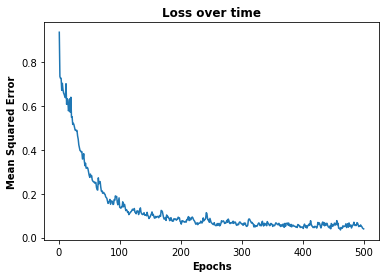

Train MSE: 0.0398
Test MSE: 1.0116


In [23]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric_temporal.nn.attention import STConv
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

from torch_geometric.data import DataLoader

loader = ChickenpoxDatasetLoader()

lags = 10
stride = 1
epochs = 500
batch_size = 32

dataset = loader.get_dataset(lags)

sample = next(iter(dataset))
num_nodes = sample.x.size(0)
edge_index = sample.edge_index
edge_weight = sample.edge_attr

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.4)

train_loader = DataLoader(list(train_dataset), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(test_dataset), batch_size=batch_size, shuffle=False)

### MODEL DEFINITION
class AttentionGCN(nn.Module):
    def __init__(self, num_nodes, lags):
        super(AttentionGCN, self).__init__()
                      
        self.num_nodes = num_nodes
        self.kernel_size = 3
        self.pad_size = self.kernel_size - 1

        self.gnn = STConv(
            num_nodes=self.num_nodes, 
            in_channels=1, 
            hidden_channels=32, 
            out_channels=32, 
            kernel_size=self.kernel_size, 
            K=1)

        self.conv = nn.Sequential( 
            nn.Conv2d(
                in_channels=32,
                out_channels=16,
                kernel_size=(1, lags),
                bias=True,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=1,
                kernel_size=(1, 1),
                bias=True,
            )
        )


    def forward(self, window):
        # print(window.x.shape)
        x = F.pad(window.x, (self.pad_size,self.pad_size))
        x = x.view(-1, num_nodes, lags+2*self.pad_size, 1).permute(0,2,1,3)
   
        H = F.relu(self.gnn(x, edge_index, edge_weight)) # -> (batch, lags, num_nodes, out_channels)

        H = H.permute(0, 3, 2, 1) # -> (batch, out_channels, num_nodes, lags)
        x = self.conv(H).squeeze(3) # -> (batch, num_nodes, lags)
        
        x = x.flatten()

        return x
    
model = AttentionGCN(num_nodes=num_nodes, lags=lags)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### TRAIN
model.train()

loss_history = []
for _ in tqdm(range(epochs)):
    total_loss = 0
    for i, window in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(window)
        
        assert y_pred.shape == window.y.shape
        loss = torch.mean((y_pred - window.y)**2)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    total_loss /= i+1
    loss_history.append(total_loss)

### TEST 
model.eval()
loss = 0
with torch.no_grad():
    for i, window in enumerate(test_loader):
        y_pred = model(window)
        
        assert y_pred.shape == window.y.shape
        loss += torch.mean((y_pred - window.y)**2)
    loss /= i+1

### RESULTS PLOT
fig, ax = plt.subplots()

x_ticks = np.arange(1, epochs+1)
ax.plot(x_ticks, loss_history)

# figure labels
ax.set_title('Loss over time', fontweight='bold')
ax.set_xlabel('Epochs', fontweight='bold')
ax.set_ylabel('Mean Squared Error', fontweight='bold')
plt.show()

print("Train MSE: {:.4f}".format(total_loss))
print("Test MSE: {:.4f}".format(loss))
